# Fantasy Premier League Predictor

The Fantasy Premier League (FPL) has gained immense popularity among football fans worldwide, allowing them to manage virtual teams of real-life players and compete against other FPL managers based on the performance of those players in the English Premier League. One key aspect of FPL success is accurately predicting player scores, as it enables managers to make informed decisions about team selection, transfers, and captain choices. In this project, we aim to develop a Fantasy Premier League predictor that utilizes machine learning techniques to forecast the scores of individual players in the upcoming season. By leveraging historical data and implementing feature engineering, preprocessing, and model training, we strive to provide FPL managers with valuable insights that can improve their team performance and increase their chances of success in the game.


## 1. Importing Data

We will primarily be using scikit learn to implemnent this predictor, below are the necessary imports done for this project.

In [140]:
import os

%matplotlib inline
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import tests_hw5
from sklearn import datasets
from sklearn.svm import SVR

from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso


from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from xgboost import XGBClassifier


## 2. Train and Test Data

For now, the training set will be players from the 2021 season, we will perform a natural inner join with the 2022 data to get the points from the followings season. 

In [141]:
df_2018 = pd.read_csv('2018_stats.csv')
df_2019 = pd.read_csv('2019_stats.csv')
df_2020 = pd.read_csv('2020_stats.csv')
df_2021 = pd.read_csv('2021_stats.csv')
df_2022 = pd.read_csv('2022_stats.csv')

players_train1 = pd.merge(df_2021, df_2022[['first_name', 'second_name', 'total_points', 'minutes']], on=['first_name', 'second_name'], suffixes=('_1', ''), how='inner')
players_train2 = pd.merge(df_2020, df_2021[['first_name', 'second_name', 'total_points', 'minutes']], on=['first_name', 'second_name'], suffixes=('_1', ''), how='inner')
players_train3 = pd.merge(df_2019, df_2020[['first_name', 'second_name', 'total_points', 'minutes']], on=['first_name', 'second_name'], suffixes=('_1', ''), how='inner')
players_train4 = pd.merge(df_2018, df_2019[['first_name', 'second_name', 'total_points', 'minutes']], on=['first_name', 'second_name'], suffixes=('_1', ''), how='inner')


players_train = pd.concat([players_train1, players_train2, players_train3, players_train4])

# Calculate the difference in minutes between the two seasons
minutes_diff = players_train['minutes_1'] - players_train['minutes']

# Set a threshold for significant difference
minutes_threshold = 700

# Filter out players whose minutes have a significant difference
players_train = players_train[abs(minutes_diff) <= minutes_threshold]
players_train = players_train[players_train['minutes'] >= 500]
players_train = players_train[players_train['element_type'] != 'GK']
players_train = players_train[players_train['total_points'] > 40]



players_train.drop(columns = {'minutes'})

X_train = players_train.drop(columns='total_points')
y_train = players_train['total_points']

X_train.head()



,first_name,second_name,goals_scored,assists,total_points_1,minutes_1,goals_conceded,creativity,influence,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost,element_type,minutes
2,Alexandre,Lacazette,13,3,129,1916,21,307.4,602.4,797.0,21,452,170.4,7,0,3,4.3,84,FWD,1773
4,Granit,Xhaka,1,2,70,2519,27,327.6,456.0,154.0,1,396,94.0,10,1,7,0.4,52,MID,2327
7,Calum,Chambers,0,3,36,751,10,169.4,171.8,77.0,3,168,41.9,2,0,0,0.2,45,DEF,999
10,Kieran,Tierney,1,4,96,2299,27,490.1,446.4,201.0,4,483,113.9,8,0,4,4.3,52,DEF,1916
14,Edward,Nketiah,2,1,36,411,6,97.3,116.6,211.0,5,120,42.1,1,0,0,0.5,53,FWD,823


In [142]:
df_2022 = pd.read_csv('2022_stats.csv')
df_2023 = pd.read_csv('2023_stats.csv')

players_test = pd.merge(df_2022, df_2023[['first_name', 'second_name', 'total_points', 'minutes']], on=['first_name', 'second_name'], suffixes=('_1', ''), how='inner')
minutes_diff = players_test['minutes_1'] - players_test['minutes']

# Set a threshold for significant difference
minutes_threshold = 500

# Filter out players whose minutes have a significant difference
players_test = players_test[abs(minutes_diff) <= minutes_threshold]
players_test = players_test[players_test['minutes'] >= 300]
players_test = players_test[players_test['element_type'] != 'GK']
players_test = players_test[players_test['total_points'] > 40]


players_test.drop(columns = {'minutes'})
X_test = players_test.drop(columns='total_points')
X_test.head()



,first_name,second_name,goals_scored,assists,total_points_1,minutes_1,goals_conceded,creativity,influence,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost,element_type,minutes
5,Thomas,Partey,2,2,71,2027,25,275.5,359.6,394.0,4,345,103.0,10,0,6,0.2,50,MID,2480
9,Bukayo,Saka,11,9,179,2978,39,942.5,774.2,1404.0,18,566,311.8,13,0,6,28.8,67,MID,3183
15,Martin,Ødegaard,7,4,131,2782,39,1012.4,625.6,572.0,9,541,220.3,11,0,4,6.0,56,MID,3132
22,John,McGinn,3,4,110,3090,48,777.4,692.8,307.0,12,495,177.8,10,0,8,1.1,56,MID,2692
24,Tyrone,Mings,1,4,118,3188,49,130.9,649.2,309.0,12,596,108.8,11,0,11,6.9,50,DEF,3150


In [143]:
y_test = players_test['total_points']
pd.DataFrame(y_test.head())

,total_points
5,86
9,202
15,212
22,90
24,130


# 3. Exploratory Data Analysis and Feature Engineering

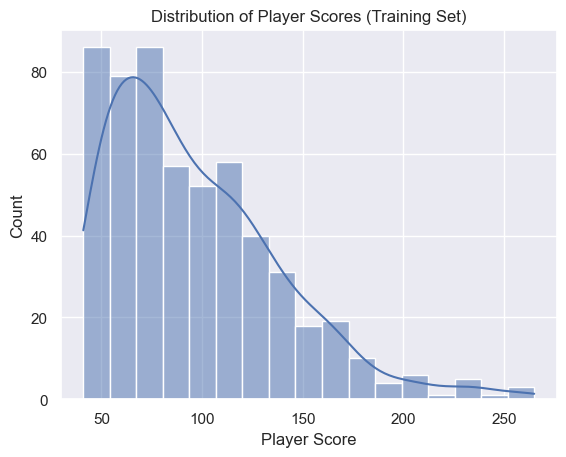

In [144]:
import seaborn as sns
sns.histplot(players_train['total_points'], kde=True)
plt.xlabel('Player Score')
plt.ylabel('Count')
plt.title('Distribution of Player Scores (Training Set)')
plt.show()


/var/folders/wj/n9lp0nt97_93cb4ny745dtw40000gq/T/ipykernel_11146/4041708221.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = pd.concat((y_train, X_train), axis=1).iloc[:, :30].corr()


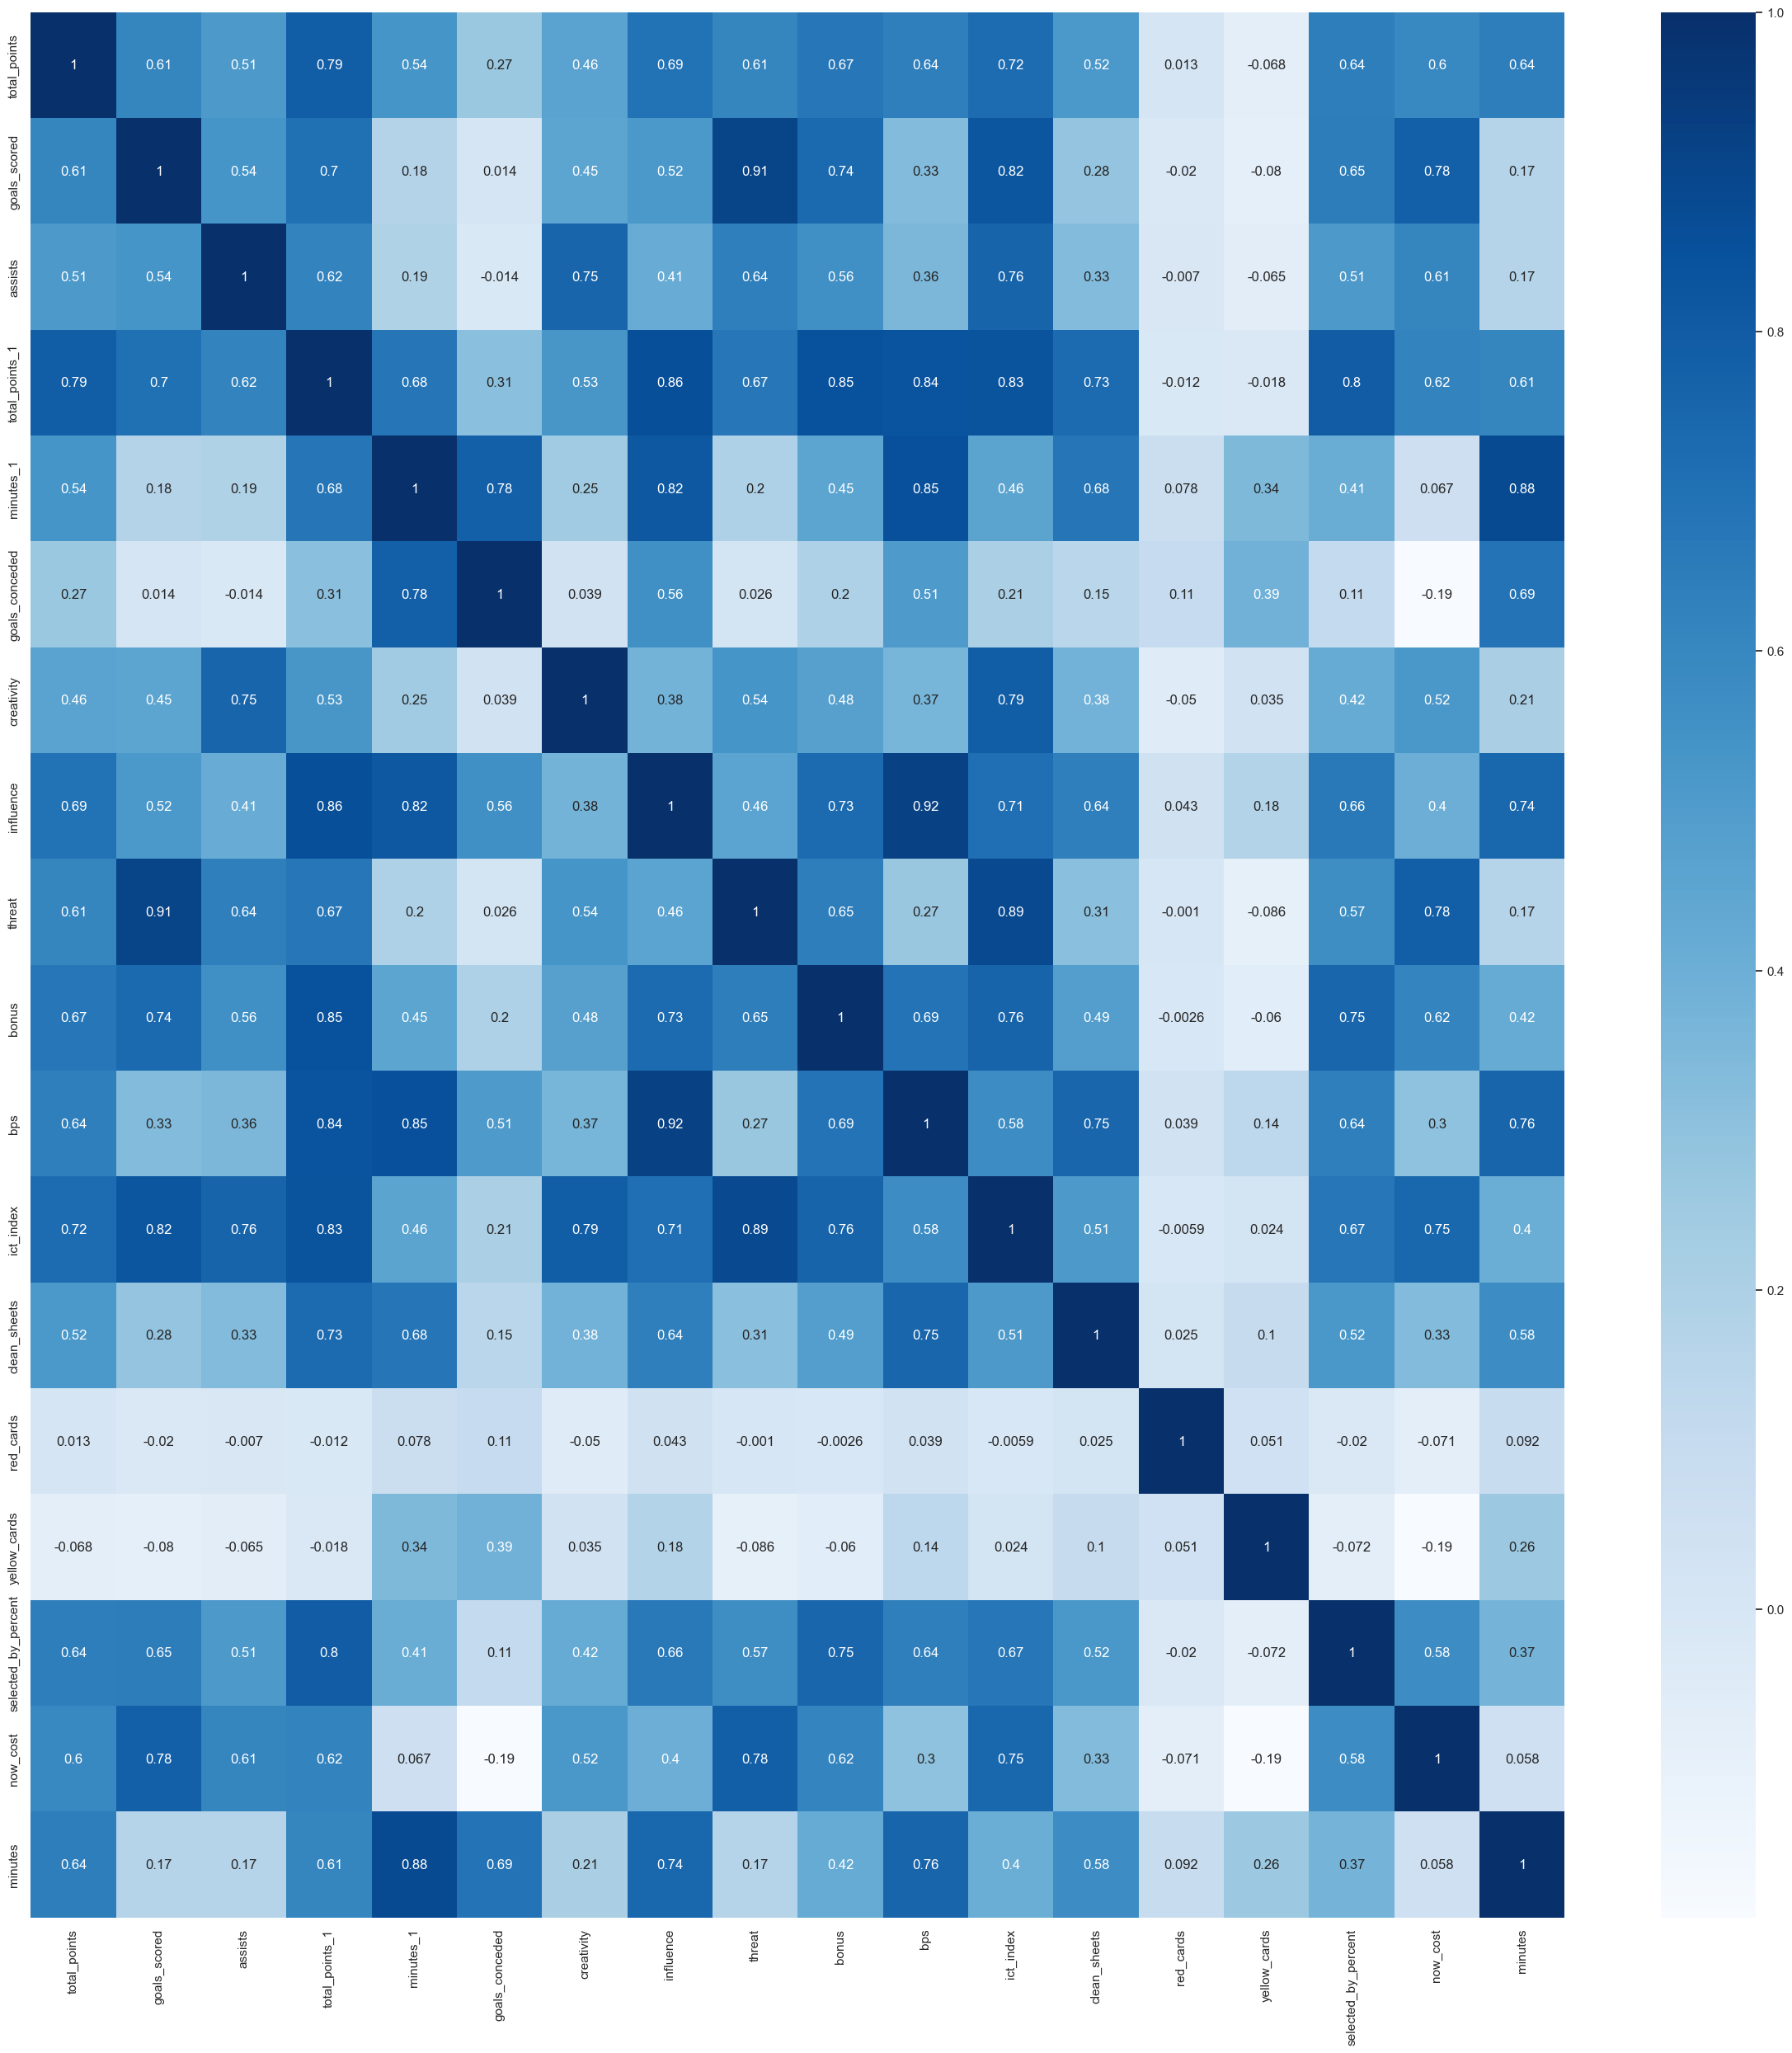

In [145]:
cor = pd.concat((y_train, X_train), axis=1).iloc[:, :30].corr()
plt.figure(figsize=(30, 30))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

As we can see here, different features may become relevant depending on other features values, such as clean sheets when the position is a goalkeeper. For this reason, I will be testing out this full dataset using predictor, and then train 4 other predictors for every position category.

I will add a new column called points per minute, to combat any bias happening due to injuries.

In [146]:

X_train['goal_involvement'] = X_train['goals_scored'] + X_train['assists']
X_test['goal_involvement'] = X_test['goals_scored'] + X_test['assists']

X_train['goal_involvement_per_m'] = (X_train['goals_scored'] + X_train['assists']) / X_train['minutes']
X_test['goal_involvement_per_m'] = (X_test['goals_scored'] + X_test['assists']) / X_test['minutes']

X_train.info()






<class 'pandas.core.frame.DataFrame'>
Int64Index: 556 entries, 2 to 411
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   first_name              556 non-null    object 
 1   second_name             556 non-null    object 
 2   goals_scored            556 non-null    int64  
 3   assists                 556 non-null    int64  
 4   total_points_1          556 non-null    int64  
 5   minutes_1               556 non-null    int64  
 6   goals_conceded          556 non-null    int64  
 7   creativity              556 non-null    float64
 8   influence               556 non-null    float64
 9   threat                  556 non-null    float64
 10  bonus                   556 non-null    int64  
 11  bps                     556 non-null    int64  
 12  ict_index               556 non-null    float64
 13  clean_sheets            556 non-null    int64  
 14  red_cards               556 non-null    in

Lets visualize how important it will be:

/var/folders/wj/n9lp0nt97_93cb4ny745dtw40000gq/T/ipykernel_11146/4041708221.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = pd.concat((y_train, X_train), axis=1).iloc[:, :30].corr()


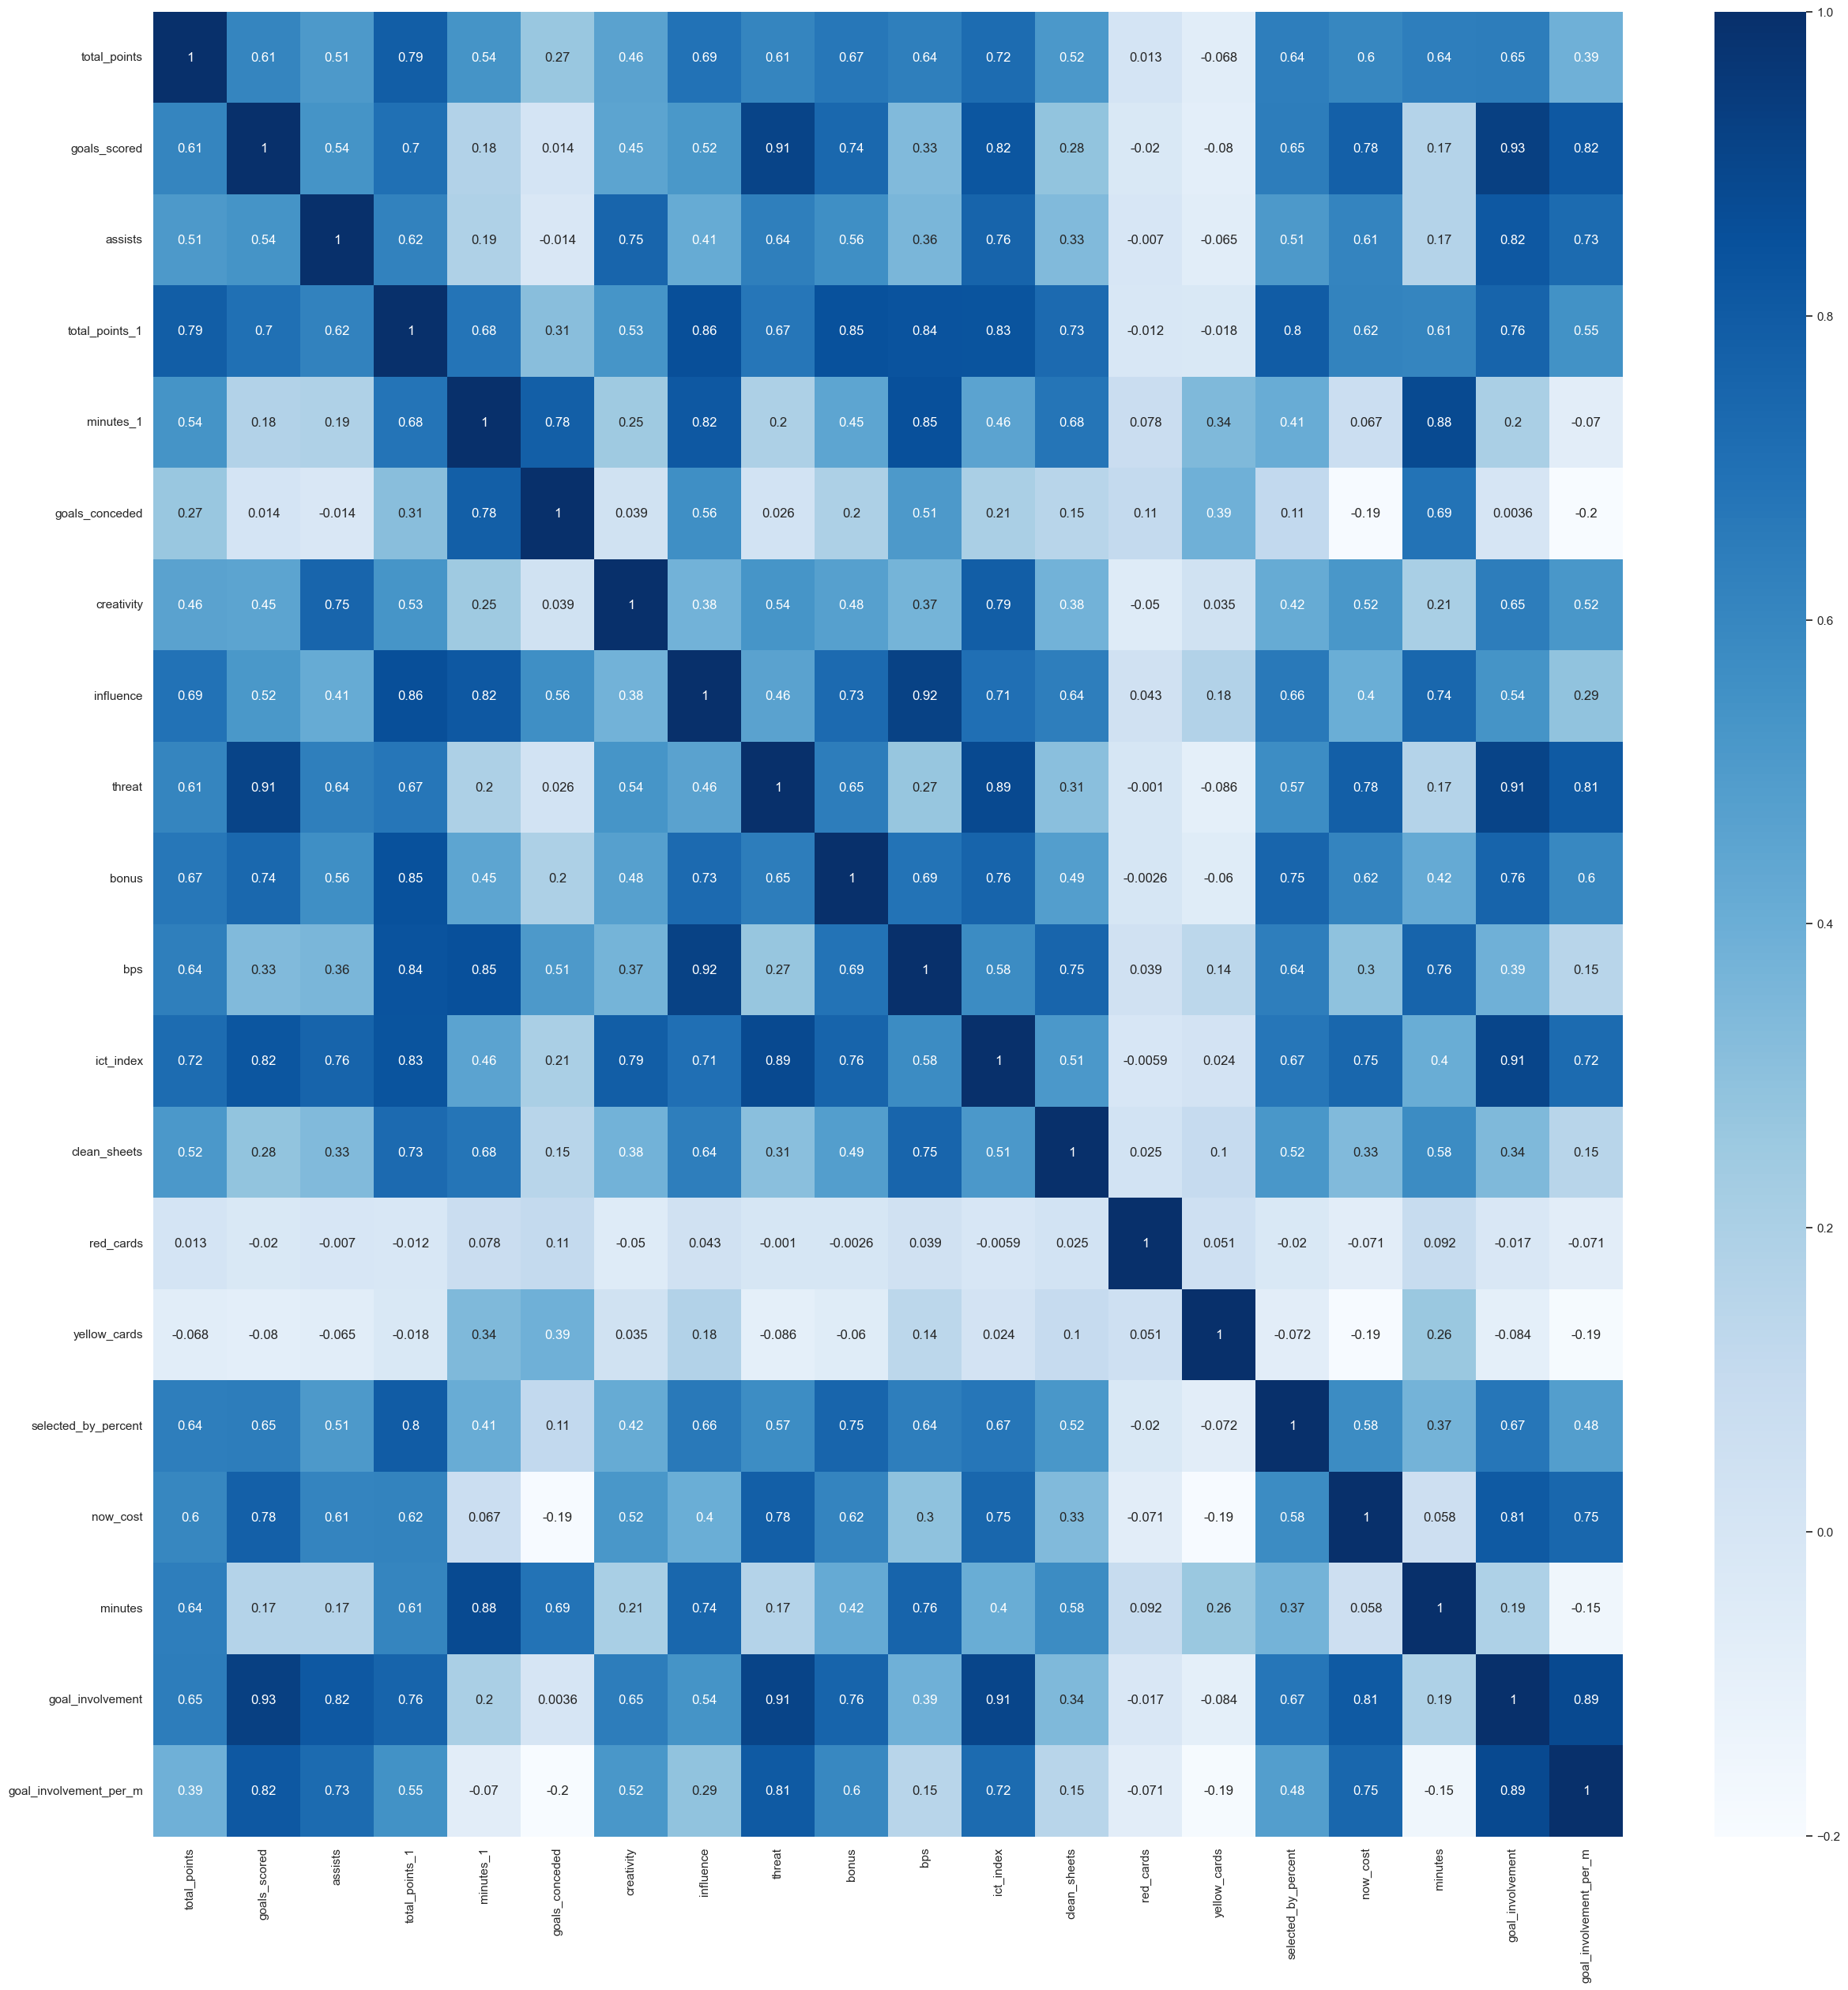

In [147]:
cor = pd.concat((y_train, X_train), axis=1).iloc[:, :30].corr()
plt.figure(figsize=(30, 30))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

They seem to be negatively correlated, which is interesting.

# 5. Data Preprocessing

To ensure that no categories are dominating when they shouldnt be, and all categories are numerical, I will conduct preprocessing which will include scaling and One hot encoding.

In [148]:
players_train.describe()

,goals_scored,assists,total_points_1,minutes_1,goals_conceded,creativity,influence,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost,total_points,minutes
count,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000
mean,3.679856,3.116906,97.910072,2218.577338,31.043165,352.750719,523.192086,415.455036,8.356115,428.604317,129.111151,8.007194,0.129496,3.494604,5.394784,58.059353,96.370504,2200.902878
std,4.919352,3.193857,45.137578,769.945375,13.557018,288.612536,238.406688,409.154302,7.157871,178.557982,75.905839,3.947852,0.356854,2.688978,8.028696,16.472584,42.548450,718.481558
min,0.000000,0.000000,13.000000,134.000000,0.000000,0.000000,60.200000,0.000000,0.000000,46.000000,17.100000,0.000000,0.000000,0.000000,0.000000,39.000000,41.000000,548.000000
25%,0.000000,1.000000,65.000000,1714.250000,21.000000,127.825000,341.250000,129.750000,3.000000,299.500000,75.975000,5.000000,0.000000,1.000000,0.700000,48.000000,63.000000,1653.750000
50%,2.000000,2.000000,92.000000,2280.500000,31.000000,299.200000,504.800000,275.500000,7.000000,413.000000,108.150000,8.000000,0.000000,3.000000,2.200000,53.000000,87.000000,2234.500000
75%,5.000000,5.000000,125.000000,2813.250000,40.250000,482.250000,690.950000,543.500000,12.000000,552.000000,163.875000,10.250000,0.000000,5.000000,6.500000,61.000000,120.000000,2778.000000
max,32.000000,17.000000,303.000000,3420.000000,68.000000,1515.000000,1496.200000,2355.000000,40.000000,932.000000,454.400000,21.000000,2.000000,14.000000,56.700000,132.000000,265.000000,3420.000000


In [149]:
drop_features = ["first_name", 'second_name', 'red_cards', 'yellow_cards', "selected_by_percent", ]
numeric_features = [
    "goals_scored",
    'goal_involvement',
    'goal_involvement_per_m',
    "assists",
    "goals_conceded",
    "creativity",
    "influence",
    "threat",
    "bonus",
    "bps",
    "ict_index",
    "clean_sheets",
    "now_cost",
    'minutes_1', 
    
]
categorical_features = ["element_type"]
target = "total_points"

In [150]:
preprocessor = make_column_transformer(
    ("drop", drop_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
)

In [151]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

results = {}



In [152]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 556 entries, 2 to 411
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   first_name              556 non-null    object 
 1   second_name             556 non-null    object 
 2   goals_scored            556 non-null    int64  
 3   assists                 556 non-null    int64  
 4   total_points_1          556 non-null    int64  
 5   minutes_1               556 non-null    int64  
 6   goals_conceded          556 non-null    int64  
 7   creativity              556 non-null    float64
 8   influence               556 non-null    float64
 9   threat                  556 non-null    float64
 10  bonus                   556 non-null    int64  
 11  bps                     556 non-null    int64  
 12  ict_index               556 non-null    float64
 13  clean_sheets            556 non-null    int64  
 14  red_cards               556 non-null    in

# 6. Baseline Model

In [153]:
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

dummy_pipe = make_pipeline(preprocessor, DummyRegressor())


results["dummy"] = mean_std_cross_val_scores(
    dummy_pipe, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)

)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.001),0.003 (+/- 0.001),34.015 (+/- 1.742),33.863 (+/- 0.553)


We see here that the dummy classifier is predicting on average off by approximately 49 points, which is not up to our standards.

# Trying out Models

I will be testing out various regression algorithms and ensembles to try to find the best performing model while minimizing the overfitting on the training set.

## Ridge:

In [154]:
ridge_pipe = make_pipeline(preprocessor, RidgeCV(cv = 5, scoring=make_scorer(mean_absolute_error)))

results["Ridge"] = mean_std_cross_val_scores(
    ridge_pipe, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)

)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.001),0.003 (+/- 0.001),34.015 (+/- 1.742),33.863 (+/- 0.553)
Ridge,0.019 (+/- 0.003),0.003 (+/- 0.000),19.678 (+/- 2.008),18.467 (+/- 0.389)


## Random Forest:

In [155]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [None, 5, 10],
    'randomforestregressor__min_samples_split': [2, 5, 10]
}

random_forest_pipe = make_pipeline(preprocessor, RandomForestRegressor())

random_search = RandomizedSearchCV(random_forest_pipe, param_distributions=param_grid, scoring=make_scorer(mean_absolute_error), cv=5, n_iter=10, n_jobs=-1)
random_search.fit(X_train, y_train)

best_random_forest = random_search.best_estimator_
best_score = random_search.best_score_

random_forest_pipe = best_random_forest

results["Random Forest"] = mean_std_cross_val_scores(
    random_forest_pipe, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)
)

pd.DataFrame(results).T



,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.001),0.003 (+/- 0.001),34.015 (+/- 1.742),33.863 (+/- 0.553)
Ridge,0.019 (+/- 0.003),0.003 (+/- 0.000),19.678 (+/- 2.008),18.467 (+/- 0.389)
Random Forest,0.615 (+/- 0.002),0.018 (+/- 0.000),19.809 (+/- 1.554),14.303 (+/- 0.272)


# SVC:

In [156]:
from sklearn.svm import SVR


# Hyperparameter options
svc_param_grid = {
    'svr__C': [0.1, 1.0, 10.0, 100, 1000],
    'svr__gamma': [0.01, 0.1, 1.0, 10.0, 100]
}



svc_pipe = make_pipeline(preprocessor, SVR(kernel = 'linear'))

svc_grid_search = GridSearchCV(svc_pipe, param_grid=svc_param_grid, scoring=make_scorer(mean_absolute_error), cv=5, return_train_score = True)
svc_grid_search.fit(X_train, y_train)

best_svc = svc_grid_search.best_estimator_

results["SVC"] = mean_std_cross_val_scores(
    best_svc, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)
)

pd.DataFrame(results).T



,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.001),0.003 (+/- 0.001),34.015 (+/- 1.742),33.863 (+/- 0.553)
Ridge,0.019 (+/- 0.003),0.003 (+/- 0.000),19.678 (+/- 2.008),18.467 (+/- 0.389)
Random Forest,0.615 (+/- 0.002),0.018 (+/- 0.000),19.809 (+/- 1.554),14.303 (+/- 0.272)
SVC,0.012 (+/- 0.000),0.004 (+/- 0.000),20.665 (+/- 1.347),20.189 (+/- 0.293)


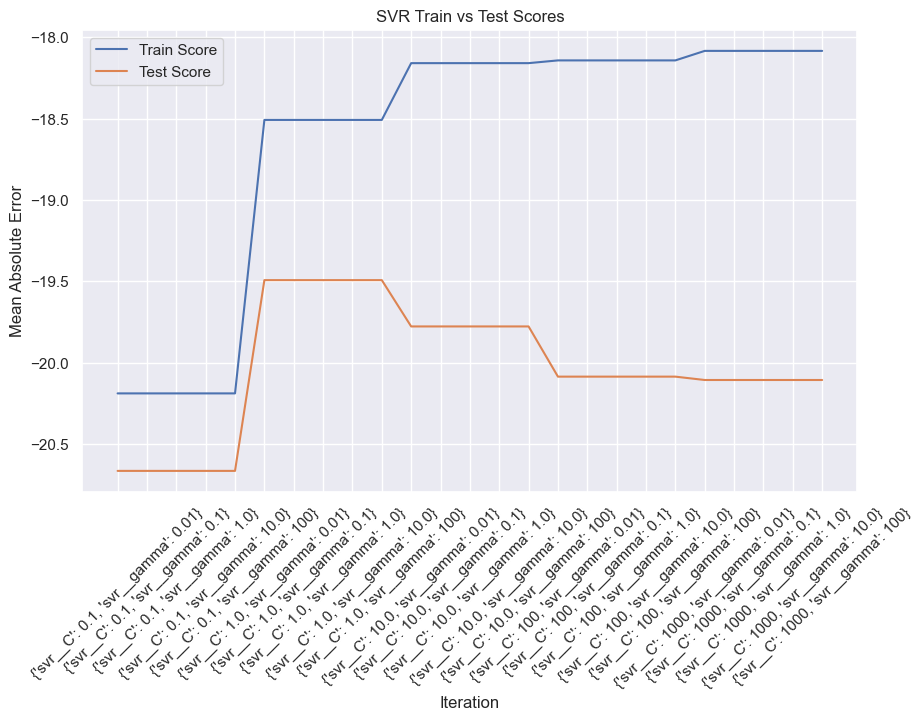

In [157]:
svc_results = svc_grid_search.cv_results_
svc_mean_train_scores = -svc_results['mean_train_score']
svc_mean_test_scores = -svc_results['mean_test_score']
svc_params = svc_results['params']

plt.figure(figsize=(10, 6))
plt.plot(range(len(svc_mean_train_scores)), svc_mean_train_scores, label='Train Score')
plt.plot(range(len(svc_mean_test_scores)), svc_mean_test_scores, label='Test Score')

plt.xticks(range(len(svc_params)), [str(params) for params in svc_params], rotation=45)
plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.title('SVR Train vs Test Scores')
plt.legend()
plt.show()


## KNN: 

In [158]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

knn_param_grid = {
    'kneighborsregressor__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
}


knn_pipe = make_pipeline(preprocessor, KNeighborsRegressor())

knn_grid_search = GridSearchCV(knn_pipe, param_grid=knn_param_grid, scoring='neg_mean_absolute_error', cv=5, return_train_score = True)
knn_grid_search.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('drop',
                                                                         'drop',
                                                                         ['first_name',
                                                                          'second_name',
                                                                          'red_cards',
                                                                          'yellow_cards',
                                                                          'selected_by_percent']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['goals_scored',
                                                                          'goal_involvement',
                                                                          'goal_involvement_per_m',
                                                                          'assists',
                                                                          'goals_conceded',
                                                                          'creativity',
                                                                          'influence',
                                                                          'threat',
                                                                          'bonus',
                                                                          'bps',
                                                                          'ict_index',
                                                                          'clean_sheets',
                                                                          'now_cost',
                                                                          'minutes_1']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['element_type'])])),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'kneighborsregressor__n_neighbors': [3, 5, 7, 9, 11,
                                                              13, 15]},
             return_train_score=True, scoring='neg_mean_absolute_error')

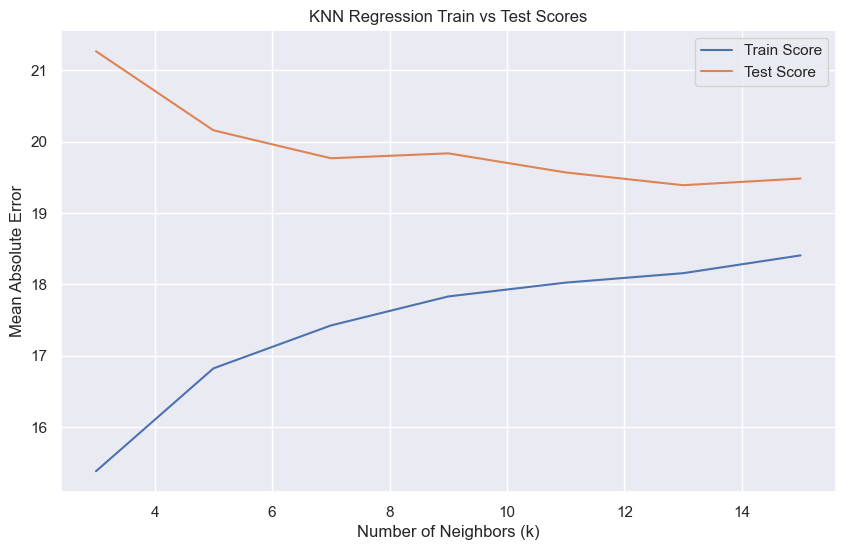

In [159]:
knn_results = knn_grid_search.cv_results_
mean_train_scores = -knn_results['mean_train_score']
mean_test_scores = -knn_results['mean_test_score']
param_values = knn_results['param_kneighborsregressor__n_neighbors']

plt.figure(figsize=(10, 6))
plt.plot(param_values, mean_train_scores, label='Train Score')
plt.plot(param_values, mean_test_scores, label='Test Score')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error')
plt.title('KNN Regression Train vs Test Scores')
plt.legend()
plt.show()


In [160]:
best_knn = make_pipeline(preprocessor, KNeighborsRegressor(n_neighbors = 17))


results["KNN"] = mean_std_cross_val_scores(
    best_knn, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)
)

pd.DataFrame(results).T


,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.001),0.003 (+/- 0.001),34.015 (+/- 1.742),33.863 (+/- 0.553)
Ridge,0.019 (+/- 0.003),0.003 (+/- 0.000),19.678 (+/- 2.008),18.467 (+/- 0.389)
Random Forest,0.615 (+/- 0.002),0.018 (+/- 0.000),19.809 (+/- 1.554),14.303 (+/- 0.272)
SVC,0.012 (+/- 0.000),0.004 (+/- 0.000),20.665 (+/- 1.347),20.189 (+/- 0.293)
KNN,0.007 (+/- 0.003),0.006 (+/- 0.002),19.445 (+/- 1.085),18.578 (+/- 0.477)


# Gradient Boosting Regressor

In [161]:
from sklearn.ensemble import GradientBoostingRegressor

gb_param_grid = {
    'gradientboostingregressor__n_estimators': [100, 200, 300],
    'gradientboostingregressor__max_depth': [3, 5, 7],
    'gradientboostingregressor__learning_rate': [0.1, 0.01, 0.001]
}

gb_pipe = make_pipeline(preprocessor, GradientBoostingRegressor())

gb_grid_search = GridSearchCV(gb_pipe, param_grid=gb_param_grid, scoring=make_scorer(mean_absolute_error), cv=5, return_train_score=True)
gb_grid_search.fit(X_train, y_train)

best_gb = gb_grid_search.best_estimator_

results["Gradient Boosting"] = mean_std_cross_val_scores(
    best_gb, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)
)

pd.DataFrame(results).T


,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.001),0.003 (+/- 0.001),34.015 (+/- 1.742),33.863 (+/- 0.553)
Ridge,0.019 (+/- 0.003),0.003 (+/- 0.000),19.678 (+/- 2.008),18.467 (+/- 0.389)
Random Forest,0.615 (+/- 0.002),0.018 (+/- 0.000),19.809 (+/- 1.554),14.303 (+/- 0.272)
SVC,0.012 (+/- 0.000),0.004 (+/- 0.000),20.665 (+/- 1.347),20.189 (+/- 0.293)
KNN,0.007 (+/- 0.003),0.006 (+/- 0.002),19.445 (+/- 1.085),18.578 (+/- 0.477)
Gradient Boosting,0.137 (+/- 0.001),0.003 (+/- 0.000),32.067 (+/- 1.662),31.791 (+/- 0.515)


# Voting Ensemble:

## LGBM:

In [ ]:
from sklearn.ensemble import  AdaBoostRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import RidgeCV, BayesianRidge

# LGBMRegressor
lgbm_param_grid = {
    'lgbmregressor__n_estimators': [100, 200, 300],
    'lgbmregressor__max_depth': [1, 3, 5, 7, 9],
    'lgbmregressor__learning_rate': [0.1, 0.01, 0.001]
}

lgbm_pipe = make_pipeline(preprocessor, LGBMRegressor())

lgbm_grid_search = GridSearchCV(lgbm_pipe, param_grid=lgbm_param_grid, scoring=make_scorer(mean_absolute_error), cv=5, return_train_score=True)
lgbm_grid_search.fit(X_train, y_train)

best_lgbm = lgbm_grid_search.best_estimator_

results["LGBMRegressor"] = mean_std_cross_val_scores(
    best_lgbm, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)
)
pd.DataFrame(results).T



# AdaBoostRegressor


In [ ]:
adaboost_param_grid = {
    'adaboostregressor__n_estimators': [50, 100, 150],
    'adaboostregressor__learning_rate': [0.1, 0.01, 0.001]
}

adaboost_pipe = make_pipeline(preprocessor, AdaBoostRegressor())

adaboost_grid_search = GridSearchCV(adaboost_pipe, param_grid=adaboost_param_grid, scoring=make_scorer(mean_absolute_error), cv=5, return_train_score=True)
adaboost_grid_search.fit(X_train, y_train)

best_adaboost = adaboost_grid_search.best_estimator_

results["AdaBoostRegressor"] = mean_std_cross_val_scores(
    best_adaboost, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)
)

pd.DataFrame(results).T


# ExtraTreesRegressor


In [ ]:
extratrees_param_grid = {
    'extratreesregressor__n_estimators': [100, 200, 300],
    'extratreesregressor__max_depth': [3, 5, 7]
}

extratrees_pipe = make_pipeline(preprocessor, ExtraTreesRegressor())

extratrees_grid_search = GridSearchCV(extratrees_pipe, param_grid=extratrees_param_grid, scoring=make_scorer(mean_absolute_error), cv=5, return_train_score=True)
extratrees_grid_search.fit(X_train, y_train)

best_extratrees = extratrees_grid_search.best_estimator_

results["ExtraTreesRegressor"] = mean_std_cross_val_scores(
    best_extratrees, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)
)

pd.DataFrame(results).T



In [ ]:
from sklearn.ensemble import BaggingRegressor

bagging_param_grid = {
    'baggingregressor__n_estimators': [10, 50, 100],
    'baggingregressor__max_samples': [0.5, 0.8, 1.0],
    'baggingregressor__max_features': [0.5, 0.8, 1.0]
}

bagging_pipe = make_pipeline(preprocessor, BaggingRegressor())

bagging_grid_search = GridSearchCV(bagging_pipe, param_grid=bagging_param_grid, scoring=make_scorer(mean_absolute_error), cv=5, return_train_score=True)
bagging_grid_search.fit(X_train, y_train)

best_bagging = bagging_grid_search.best_estimator_

results["Bagging"] = mean_std_cross_val_scores(
    best_bagging, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)
)

pd.DataFrame(results).T



In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hist_param_grid = {
    'histgradientboostingregressor__max_iter': [100, 200, 300],
    'histgradientboostingregressor__learning_rate': [0.1, 0.01, 0.001]
}

hist_pipe = make_pipeline(preprocessor, HistGradientBoostingRegressor())

hist_grid_search = GridSearchCV(hist_pipe, param_grid=hist_param_grid, scoring=make_scorer(mean_absolute_error), cv=5, return_train_score=True)
hist_grid_search.fit(X_train, y_train)

best_hist = hist_grid_search.best_estimator_

results["HistGradient Boosting"] = mean_std_cross_val_scores(
    best_hist, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)
)

pd.DataFrame(results).T



In [ ]:
from xgboost import XGBRegressor

xgb_param_grid = {
    'xgbregressor__n_estimators': [50, 100, 200],
    'xgbregressor__learning_rate': [0.1, 0.01, 0.001],
    'xgbregressor__max_depth': [3, 5, 7]
}

xgb_pipe = make_pipeline(preprocessor, XGBRegressor())

xgb_grid_search = GridSearchCV(xgb_pipe, param_grid=xgb_param_grid, scoring=make_scorer(mean_absolute_error), cv=5, return_train_score=True)
xgb_grid_search.fit(X_train, y_train)

best_xgb = xgb_grid_search.best_estimator_

results["XGB"] = mean_std_cross_val_scores(
    best_xgb, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)
)

pd.DataFrame(results).T



In [ ]:
from sklearn.ensemble import VotingRegressor

# Create the ensemble model
voting_regressor = VotingRegressor(
    estimators=[
        ('ridge', ridge_pipe),
        ('random_forest', best_random_forest),
        ('svc', best_svc),
        ('knn', best_knn),
        ('lgbm', best_lgbm),
        ('extra_trees', best_extratrees),
        ('ada_boost', best_adaboost),
        ('gradient_boosting', best_gb),
        ('bagging', best_bagging),
        ('hist_gradient_boosting', best_hist),
    ]
)



results["Voting"] = mean_std_cross_val_scores(
    voting_regressor, X_train, y_train, return_train_score=True, scoring=make_scorer(mean_absolute_error)
)

pd.DataFrame(results).T



In [ ]:
from sklearn.metrics import accuracy_score

# Define a function to calculate the rank accuracy
def rank_accuracy(model, model_name):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions on the training data
    player_predictions = model.predict(X_train)

    # Create a DataFrame with player names, predicted scores, and actual scores
    player_predictions_df = pd.DataFrame({'Player': X_train['second_name'], 'Predicted Score': player_predictions, 'Actual Score': y_train})

    # Sort the DataFrame by predicted score in descending order
    player_predictions_df.sort_values(by='Predicted Score', ascending=False, inplace=True)

    # Add a column for the predicted ranking
    player_predictions_df['Predicted Rank'] = range(1, len(player_predictions_df) + 1)

    # Sort the DataFrame by actual score in descending order
    player_predictions_df.sort_values(by='Actual Score', ascending=False, inplace=True)

    # Add a column for the actual ranking
    player_predictions_df['Actual Rank'] = range(1, len(player_predictions_df) + 1)

    # Calculate the accuracy for predicted scores
    predicted_accuracy = r2_score(player_predictions_df['Actual Rank'], player_predictions_df['Predicted Rank'])

    return {model_name: predicted_accuracy}





In [ ]:
# Calculate rank accuracies for each model
ran_results = {}
ran_results.update(rank_accuracy(ridge_pipe, 'Ridge'))
ran_results.update(rank_accuracy(voting_regressor, 'Voting'))
ran_results.update(rank_accuracy(best_random_forest, 'Random Forest'))
ran_results.update(rank_accuracy(best_knn, 'KNN'))
ran_results.update(rank_accuracy(best_svc, 'SVC'))
ran_results.update(rank_accuracy(best_hist, 'HIST'))
ran_results.update(rank_accuracy(best_bagging, 'Bagging'))
ran_results.update(rank_accuracy(best_adaboost, 'Adaboost'))
ran_results.update(rank_accuracy(best_extratrees, 'ExtraTrees'))

# Create the 'ran_results' DataFrame
ran_results_df = pd.DataFrame(ran_results, index=['Accuracy'])

ran_results_df.T


In [ ]:
    best_random_forest.fit(X_train, y_train)

    # Make predictions on the training data
    player_predictions = best_random_forest.predict(X_train)

    # Create a DataFrame with player names, predicted scores, and actual scores
    player_predictions_df = pd.DataFrame({'Player': X_train['second_name'], 'Predicted Score': player_predictions, 'Actual Score': y_train})

    # Sort the DataFrame by predicted score in descending order
    player_predictions_df.sort_values(by='Predicted Score', ascending=False, inplace=True)

    # Add a column for the predicted ranking
    player_predictions_df['Predicted Rank'] = range(1, len(player_predictions_df) + 1)

    # Sort the DataFrame by actual score in descending order
    player_predictions_df.sort_values(by='Actual Score', ascending=False, inplace=True)

    # Add a column for the actual ranking
    player_predictions_df['Actual Rank'] = range(1, len(player_predictions_df) + 1)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    player_predictions_df